# *WIP:* Using the vtkInterface Package

This notebook is a work in progress to demo how PVGeo can be used with `vtki` for creating integrated visualizations directly in a Python environment. At this time, the 3D rendering is perfromed in a separate window and we have yet to embed the VTK rendering windowinf into some sort of Jupyter widget.

Maybe someone reading this knows how to embed the rendering window into a widget?!?? If so, join us on [slack](http://slack.pvgeo.org) and let's collaborate!

**DISCLAIMER:** This currently only works on versions of `vtki>=0.16.1` and `PVGeo>=1.2.0`

```sh
pip install vtki>=0.16.1
```

**Note:** You can have interactive 3D renderings by specifying `notebook=False` in the plotting routine. This will open a seprate window with the rendering.

## Overview

The goal set forth for this notebook is to use a comination of Python packages to create an integrated visualization of some data and models for a specific project. These packages and their tasks are:

- `discretize` for some file IO,
- `SimPEG` inversion results for an inverted model
- `PVGeo` for its post processing filters and data integration algorithms
- `vtki` to create the 3D renderings of the whole data scene


In [1]:
import vtki
import PVGeo
import numpy as np
import discretize

In [2]:
# Import some specific algorithms from PVGeo that we'd like to use
from PVGeo.grids import ExtractTopography
from PVGeo.ubc import TopoReader

In [3]:
# This sets the plotting theme of `vtki` to look just like a ParaView rendering
vtki.set_plot_theme('paraview')
vtki.rcParams['cmap'] = 'bwr_r'

## Load the Data

Here we load in some data we'd like to process: the [**Laguna del Maule Bouguer Gravity**](http://docs.simpeg.xyz/content/examples/04-grav/plot_laguna_del_maule_inversion.html#sphx-glr-content-examples-04-grav-plot-laguna-del-maule-inversion-py) example from the SimPEG docs.

This data scene was produced from the [Laguna del Maule Bouguer Gravity](http://docs.simpeg.xyz/content/examples/04-grav/plot_laguna_del_maule_inversion.html#sphx-glr-content-examples-04-grav-plot-laguna-del-maule-inversion-py) example provided by [Craig Miller](https://github.com/craigmillernz) (Maule volcanic field, Chile. Refer to Miller et al 2016 EPSL for full details.)

> Miller, C. A., Williams-Jones, G., Fournier, D., & Witter, J. (2017). 3D gravity inversion and thermodynamic modelling reveal properties of shallow silicic magma reservoir beneath Laguna del Maule, Chile. Earth and Planetary Science Letters, 459, 14–27. https://doi.org/10.1016/j.epsl.2016.11.007

In [4]:
# Load the a TensorMesh and some already processed model data 
mesh = discretize.TensorMesh.readUBC('craig_chile.msh', directory='data/Craig-Chile')
models = {'lpout': mesh.readModelUBC(fileName='Lpout.mod', directory='data/Craig-Chile')}

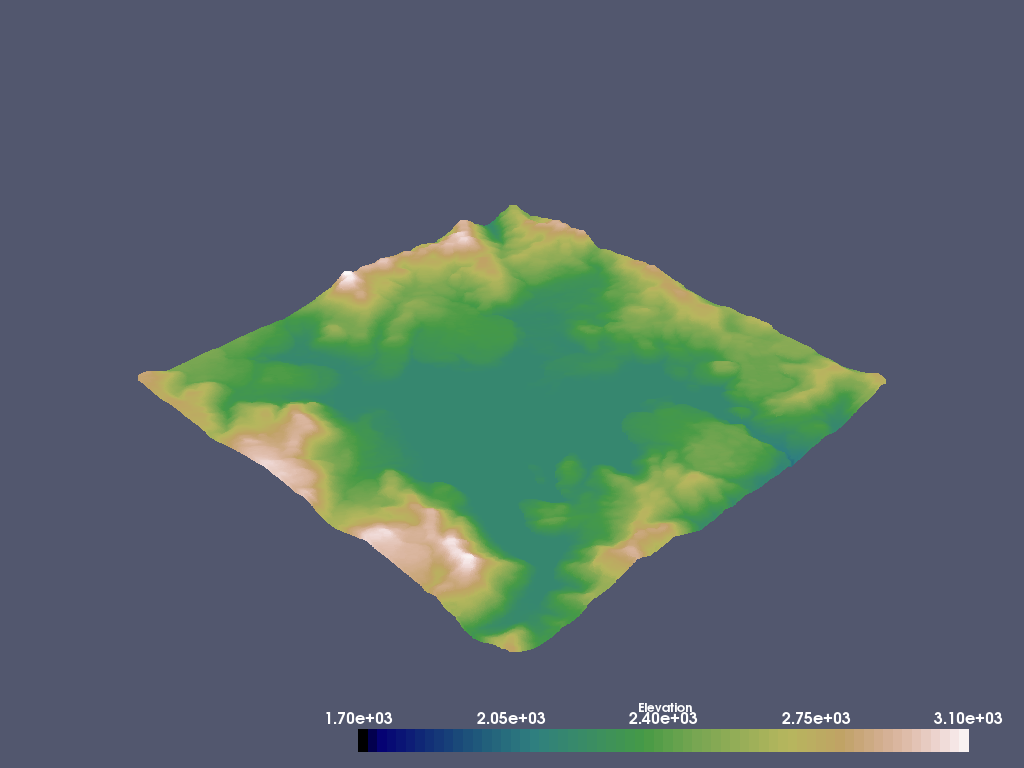

In [5]:
# Load topography data using PVGeo
topo = TopoReader().Apply('data/Craig-Chile/LdM_topo.topo')
# Note that PVGeo will return a vtki wrapped data object if vtki is available!
topo.set_active_scalar('Elevation')
topo.plot(cmap='gist_earth', rng=[1.7e+03, 3.104e+03])

## Build a Pipeline 

Here we build up a pipeline that will transform and integrate the data. This pipeline uses several algorithms taht pass their output onto the next algorithm and so forth.

In [6]:
# This adds an active cell array to describe how the topo surface splits the dataset
extractor = ExtractTopography(offset=-150, tolerance=10, op='underneath')
extracted = extractor.Apply(mesh.toVTK(models=models), topo)
extracted

(RectilinearGrid)0xb37d400a8

The `ExtractTopography` algorithm in the above cell adds a new array called `'Extracted'` that has 0s and 1s for how the topography surface splits the dataset. We can now use this array to extract the region of the model that is beneath the topography (the subsurface region of the model).

To do this, we'll use a simple `PercentThreshold` filter from PVGeo. The `PercentThreshold` algorithm defaults to threshold at 50% so it will remove all the cells with 0s and preserve the region of the model where the cells are active (the 1s). There are many ways you could threshold this model to extract the subsurface but this algorithm provides a clean way to do it with default parameters.

In [7]:
# threshold out the topography by a simple percent threshold in PVGeo
subsurface = extracted.threshold_percent(scalars='Extracted')
subsurface

(UnstructuredGrid)0xb3704d288

Note that the output of the above cell now shows a `vtkUnstructuredGrid`. This dataset contains only the cells that were extracted by the `ExtractTopography` algorithm.

In [8]:
# Get the scalar range to plot everything the same way
rng = subsurface.get_data_range('lpout')
# this range helps us create consistent and meaningful color legends

Now that we have the subsurface region of the model domain, we can use that dataset for further volume extraction and slicing. The next cell uses a filter directly from `vtki` that will threshold a specific value range of the dataset so that we will have a volumetric body to inspect.

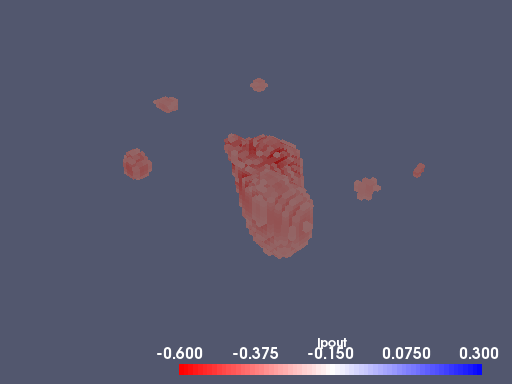

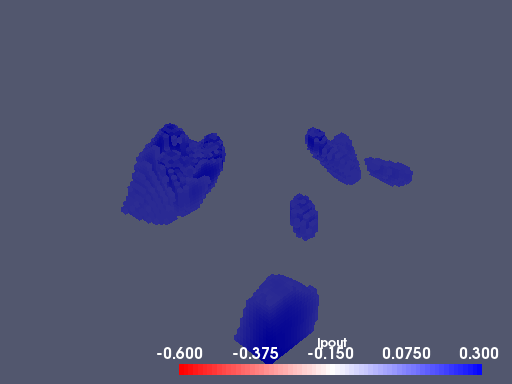

In [9]:
# threshold using vtki on a specific value
low = subsurface.threshold_percent(35, invert=True)
low.plot(rng=rng, window_size=[1024//2, 768//2])

high = subsurface.threshold_percent(85)
high.plot(rng=rng, window_size=[1024//2, 768//2])

In [10]:
# Or better yet, use an interactive tool
#vtki.Threshold(subsurface)

We can also use the `ManySlicesAlongAxis` filter from PVGeo to create `n` slices of the subsurface model dataset along a given axis. In our case, we'll slice along the Y-axis (index 1) and create 5 slices.

Note that we can interactively plot any of these datasets by ensuring the `notebook` argument is set to `False` which will open a seperate rendering window.

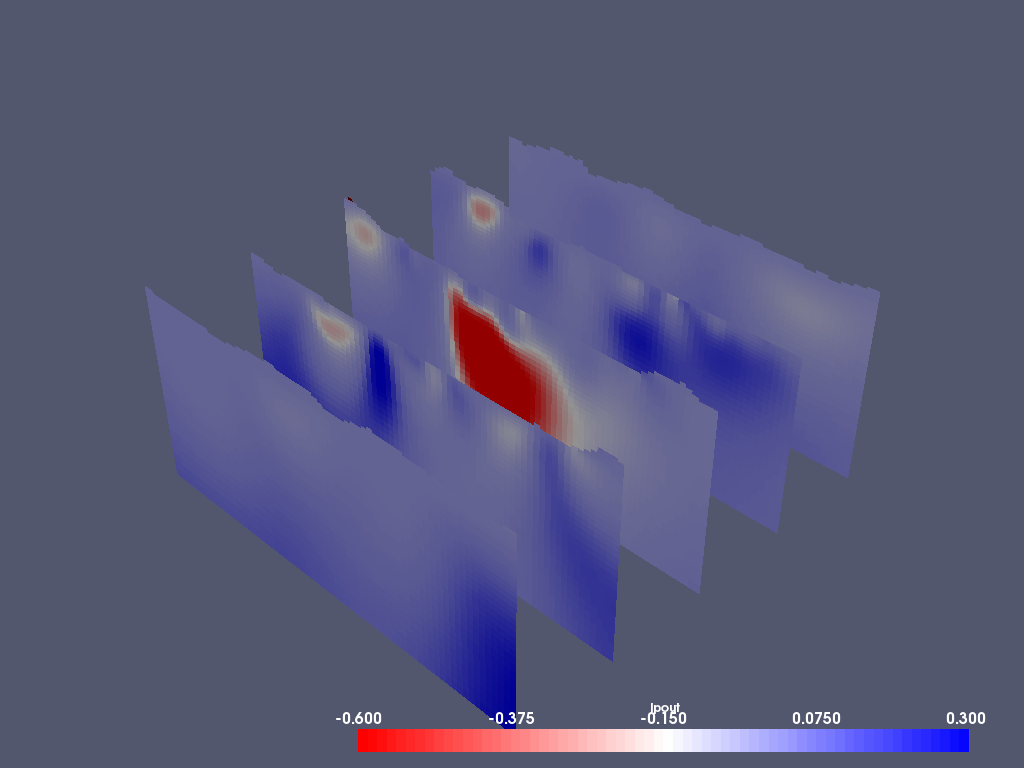

In [11]:
# Slice the subsurface model
slices = subsurface.slice_along_axis(5)
slices.plot(rng=rng, notebook=True)

## Plot in an Interactive 3D Window

Okay, so now we have all these datasets and filter products of those datasets... what if we need to spatially relat all of those datasets and interactively view them? For example, lets display the thresholded volume with the slices of the data set all underneath the topography surface:


First, we create the plotter/rendering environment:

```py
p = vtki.Plotter(notebook=False)
```

Next we add all the datasets we'd like to display by repeatedly calling `p.add_mesh` with the data object and any plotting arguments such as colormap or the scalar array you'd like to color it by:

```py
cmap = 'bwr_r'
p.add_mesh(low, scalars='lpout', rng=rng, showedges=False)
p.add_mesh(high, scalars='lpout', rng=rng, showedges=False)
p.add_mesh(slices, scalars='lpout', rng=rng, showedges=False, opacity=0.85)
p.add_mesh(topo, opacity=0.5, psize=1.0, colormap='gist_earth', rng=[1.7e+03, 3.104e+03])
```

Then we add any extra plotting labels such as the axis orientation and spatial labels/bounds:

```py
p.add_bounds_axes(extracted, color='k', fontsize=30)
p.add_axes()
```

Lastly, we call `p.show` to display the rendering windoe much like how you might use `plt.show` in `matplotlib`.

```py
p.show()
```

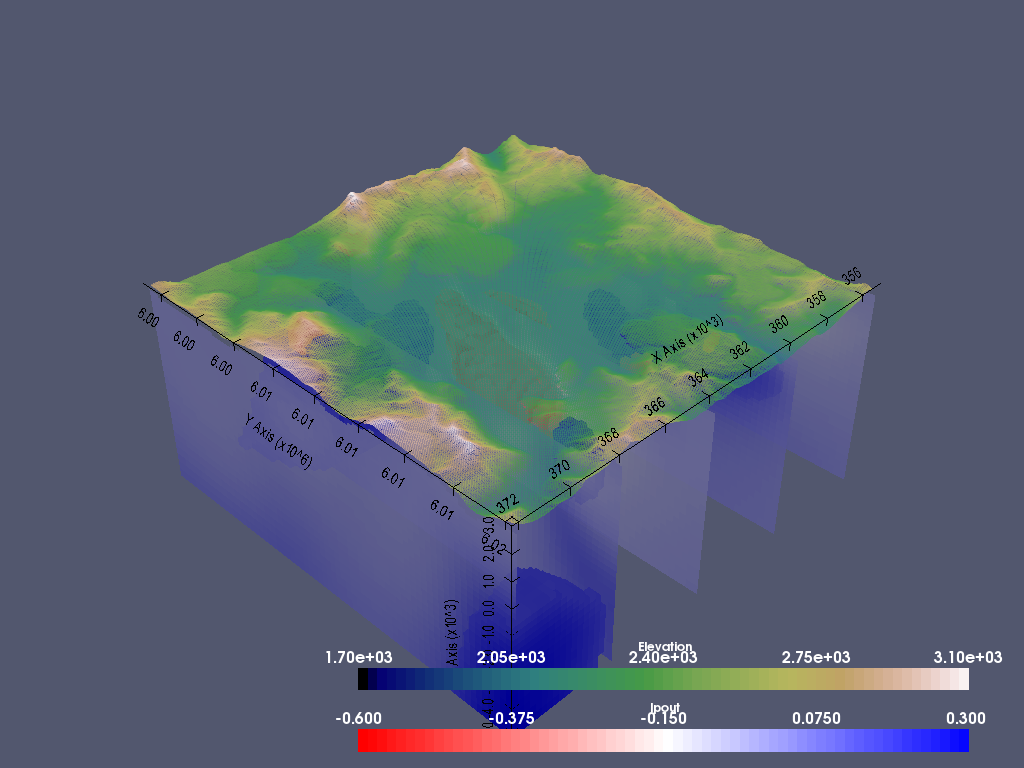

In [12]:
# Plot them all in one rendering environment!
p = vtki.Plotter(notebook=True)

#p.add_mesh(extracted, syle='wireframe', opacity=0.25, scalars='lpout', rng=rng)
p.add_mesh(low, scalars='lpout', rng=rng, show_edges=False)
p.add_mesh(high, scalars='lpout', rng=rng, show_edges=False)
p.add_mesh(slices, scalars='lpout', rng=rng, show_edges=False, opacity=0.85)
p.add_mesh(topo, opacity=0.5, point_size=1.0, cmap='gist_earth', rng=[1.7e+03, 3.104e+03])

p.add_bounds_axes(extracted, color='k', font_size=30)
p.add_axes()

p.plot()

## Or use interactive plotting tools!

You can also use interactive plotting tools to create the same scene but interact directly with the filters

In [13]:
slicer = vtki.ManySlicesAlongAxis(subsurface)

interactive(children=(IntSlider(value=5, continuous_update=False, description='n', max=10, min=1), Dropdown(de…

In [14]:
a_topo = slicer.plotter.add_mesh(topo, 
                opacity=0.5, point_size=1.0,
                cmap='gist_earth', rng=[1.7e+03, 3.104e+03])

In [16]:
thresher = vtki.Threshold(subsurface, 
                          plotter=slicer.plotter, 
                          default_params={'invert':True})


interactive(children=(FloatSlider(value=-0.375, continuous_update=False, description='dmin', max=0.3, min=-0.6…

In [17]:
slicer.plotter.add_bounds_axes()

(vtkRenderingAnnotationPython.vtkCubeAxesActor)0xb3c524588

In [18]:
# slicer.plotter.axes_actor.SetScale(1.0, 1.0, 2.0)

In [18]:
# slicer.plotter._render()